In [1]:
import numpy as np
import pandas as pd
!pip install pybaseball
import pybaseball
from matplotlib import pyplot as plt
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup, plot_stadium
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import requests
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 14.6 MB/s eta 0:00:00


In [2]:
overallBattingStats = pd.read_csv('batting_and_cumulative.csv')
totalPitchingStats = pd.read_csv('tot_pitching.csv')
FourSeamBatting = pd.read_csv('4-Seam-FB_stats.csv')
changeupBatting = pd.read_csv('changeup_stats.csv')
curveballBatting = pd.read_csv('curveball_stats.csv')
cutterBatting = pd.read_csv('cutter_stats.csv')
sinkerBatting = pd.read_csv('sinker_stats.csv')
sliderBatting = pd.read_csv('slider_stats.csv')
splitFingerBatting = pd.read_csv('split-finger_stats.csv')
sweeperBatting = pd.read_csv('sweeper_stats.csv')

In [3]:
# Most important part of the code; choosing the range of games.
# Larger date range = Better results (albeit almost all of the code runs a lot slower that way)

start_date = '2024-04-01'
end_date = '2024-04-02'
statcastData = statcast(start_dt=start_date, end_dt=end_date)

This is a large query, it may take a moment to complete


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.10/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.10/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = da

In [4]:
statcastData = statcastData.rename(columns={'batter': 'batter_id', 'pitcher': 'pitcher_id'})
statcastData['batter_id'] = statcastData['batter_id'].astype(str)
statcastData['pitcher_id'] = statcastData['pitcher_id'].astype(str)

In [5]:
def cleanNames(colName):
    colName.columns = colName.columns.str.strip()
    colName.columns = colName.columns.str.replace(' ', '_', regex=False)
    colName.columns = colName.columns.str.replace(',', '', regex=False)
    return colName

In [6]:
overallBattingStats = cleanNames(overallBattingStats)
totalPitchingStats = cleanNames(totalPitchingStats)
FourSeamBatting = cleanNames(FourSeamBatting)
changeupBatting = cleanNames(changeupBatting)
curveballBatting = cleanNames(curveballBatting)
cutterBatting = cleanNames(cutterBatting)
sinkerBatting = cleanNames(sinkerBatting)
sliderBatting = cleanNames(sliderBatting)
splitFingerBatting = cleanNames(splitFingerBatting)
sweeperBatting = cleanNames(sweeperBatting)

# Cleans the name formatting that Baseball Savant gives so it can be reformatted and renamed easier

In [7]:
overallBattingStats = overallBattingStats.rename(columns={
    'ab': 'overallABBat',
    'pa': 'overallPABat',
    'hit': 'overallHitBat',
    'single': 'overallSingleBat',
    'double': 'overallDoubleBat',
    'triple': 'overallTripleBat',
    'home_run': 'overallHomeRunBat',
    'batting_avg': 'overallAVGBat',
    'last_name_first_name': 'last_name_first_name_overall',

})

totalPitchingStats = totalPitchingStats.rename(columns={
    'ab': 'overallABPitch',
    'pitch_count': 'overallPAPitch',
    'hit': 'overallHitPitch',
    'single': 'overallSinglePitch',
    'double':'overallDoublePitch',
    'triple': 'overallTriplePitch',
    'home_run':'overallHomeRunPitch',
    'batting_avg':'overallAVGPitch',
    'last_name_first_name': 'last_name_first_name_pitching',

})


In [8]:
def rename_pitch_stats(df, pitch_type):
    return df.rename(columns={
        'player_id': 'batter_id',
        'run_value_per_100': f'run_value_per_100vs{pitch_type}',
        'run_value': f'run_valuevs{pitch_type}',
        'pitches': f'pitchesvs{pitch_type}',
        'pitch_usage': f'pitch_usagevs{pitch_type}',
        'pa': f'pavs{pitch_type}',
        'pitch_name': f'pitch_namevs{pitch_type}',
        'team_name_alt': f'team_name_altvs{pitch_type}',
        'pitch_type': f'pitch_typevs{pitch_type}',
        'ba': f'ba_vs_{pitch_type}',
        'slg': f'slg_vs_{pitch_type}',
        'woba': f'woba_vs_{pitch_type}',
        'whiff_percent': f'whiff_percentvs{pitch_type}',
        'k_percent': f'k_percentvs{pitch_type}',
        'put_away': f'put_awayvs{pitch_type}',
        'est_ba': f'est_ba_vs{pitch_type}',
        'est_slg': f'est_slg_vs{pitch_type}',
        'est_woba': f'est_woba_vs{pitch_type}',
        'hard_hit_percent': f'hard_hit_percentvs{pitch_type}',
        'last_name_first_name': f'last_name_first_name_{pitch_type}',
    })

FourSeamBatting = rename_pitch_stats(FourSeamBatting, '4seam')
changeupBatting = rename_pitch_stats(changeupBatting, 'changeup')
curveballBatting = rename_pitch_stats(curveballBatting, 'curveball')
cutterBatting = rename_pitch_stats(cutterBatting, 'cutter')
sinkerBatting = rename_pitch_stats(sinkerBatting, 'sinker')
sliderBatting = rename_pitch_stats(sliderBatting, 'slider')
splitFingerBatting = rename_pitch_stats(splitFingerBatting, 'splitfinger')
sweeperBatting = rename_pitch_stats(sweeperBatting, 'sweeper')

In [9]:
overallBattingStats = overallBattingStats.rename(columns={'player_id': 'batter_id'})
totalPitchingStats = totalPitchingStats.rename(columns={'player_id': 'pitcher_id'})
overallBattingStats['batter_id'] = overallBattingStats['batter_id'].astype(str)
totalPitchingStats['pitcher_id'] = totalPitchingStats['pitcher_id'].astype(str)

In [10]:
overallBattingStats = overallBattingStats.drop(columns=['year'], errors='ignore')
totalPitchingStats = totalPitchingStats.drop(columns=['year'], errors='ignore')

In [11]:
dataframes = [
    statcastData,
    overallBattingStats,
    totalPitchingStats,
    FourSeamBatting,
    changeupBatting,
    curveballBatting,
    cutterBatting,
    sinkerBatting,
    sliderBatting,
    splitFingerBatting,
    sweeperBatting
]
for df in dataframes:
    if 'batter_id' in df.columns:
        df['batter_id'] = df['batter_id'].astype(str)
    if 'pitcher_id' in df.columns:
        df['pitcher_id'] = df['pitcher_id'].astype(str)

for df_name, df in zip(['statcastData', 'overallBattingStats', 'totalPitchingStats',
                        'FourSeamBatting', 'changeupBatting', 'curveballBatting',
                        'cutterBatting', 'sinkerBatting', 'sliderBatting',
                        'splitFingerBatting', 'sweeperBatting'], dataframes):
    if 'batter_id' in df.columns:
        print(f"{df_name} 'batter_id' dtype: {df['batter_id'].dtype}")
    if 'pitcher_id' in df.columns:
        print(f"{df_name} 'pitcher_id' dtype: {df['pitcher_id'].dtype}")

statcastData 'batter_id' dtype: object
statcastData 'pitcher_id' dtype: object
overallBattingStats 'batter_id' dtype: object
totalPitchingStats 'pitcher_id' dtype: object
FourSeamBatting 'batter_id' dtype: object
changeupBatting 'batter_id' dtype: object
curveballBatting 'batter_id' dtype: object
cutterBatting 'batter_id' dtype: object
sinkerBatting 'batter_id' dtype: object
sliderBatting 'batter_id' dtype: object
splitFingerBatting 'batter_id' dtype: object
sweeperBatting 'batter_id' dtype: object


In [12]:
pitchTypes = ['4seam', 'changeup', 'curveball', 'cutter', 'sinker', 'slider', 'splitfinger', 'sweeper']
statcastData = statcastData.merge(overallBattingStats, on='batter_id', how='left')
statcastData = statcastData.merge(totalPitchingStats, on='pitcher_id', how='left')
pitchTypeMapping = {
    '4seam': 'FourSeamBatting',
    'changeup': 'changeupBatting',
    'curveball': 'curveballBatting',
    'cutter': 'cutterBatting',
    'sinker': 'sinkerBatting',
    'slider': 'sliderBatting',
    'splitfinger': 'splitFingerBatting',
    'sweeper': 'sweeperBatting',
}
for pitch in pitchTypes:
    frameName = pitchTypeMapping[pitch]
    pitchFrame = globals()[frameName][['batter_id', f'ba_vs_{pitch}', f'slg_vs_{pitch}', f'woba_vs_{pitch}']]
    statcastData = statcastData.merge(pitchFrame, on='batter_id', how='left')

for pitch in pitchTypes:
    statcastData[f'ba_vs_{pitch}'] = statcastData[f'ba_vs_{pitch}'].fillna(0)
    statcastData[f'slg_vs_{pitch}'] = statcastData[f'slg_vs_{pitch}'].fillna(0)
    statcastData[f'woba_vs_{pitch}'] = statcastData[f'woba_vs_{pitch}'].fillna(0)

descriptionFeatures = [f'ba_vs_{pitch}' for pitch in pitchTypeMapping] + \
                      [f'slg_vs_{pitch}' for pitch in pitchTypeMapping] + \
                      [f'woba_vs_{pitch}' for pitch in pitchTypeMapping]

In [13]:
pitchDescript = ['hit_into_play', 'blocked_ball', 'swinging_strike', 'called_strike', 'ball', 'foul']

for desc in pitchDescript:
    statcastData[f'description_{desc}'] = statcastData['description'].apply(lambda x: 1 if x == desc else 0)

In [14]:
batterFeatures = [
    'overallABBat', 'overallPABat', 'overallHitBat', 'overallSingleBat', 'overallDoubleBat',
    'overallTripleBat', 'overallHomeRunBat', 'overallAVGBat']
pitcherFeatures = [
    'overallABPitch', 'overallPAPitch', 'overallHitPitch', 'overallSinglePitch',
    'overallDoublePitch', 'overallTriplePitch', 'overallHomeRunPitch',
    'overallAVGPitch']

In [15]:
statcastData['plate_appearance_id'] = (statcastData['game_pk'].astype(str) + '_' + statcastData['at_bat_number'].astype(str))

In [16]:
featureComb = batterFeatures + pitcherFeatures + descriptionFeatures + ['balls', 'strikes']

run_value_per_100
run_value
pitches
pitch_usage
pa
ba
slg
woba
whiff_percent
k_percent
put_away
est_ba
est_slg
est_woba
hard_hit_percent

ab
pa
hit
single
double
triple
home_run
batting_avg

In [17]:
pitchDescript = ['hit_into_play', 'blocked_ball', 'swinging_strike', 'called_strike', 'ball', 'foul']
pitchOutcomes = {
    'hit_into_play': 0,
    'swinging_strike': 1,
    'called_strike': 1,
    'blocked_ball': 2,
    'ball': 2,
    'foul': 3
    }

In [18]:
pOut = statcastData.copy()
pOut['outcome'] = pOut['description'].map(pitchOutcomes)
pOut = pOut.dropna(subset=['outcome']).reset_index(drop=True)
statcastData['plate_appearance_id'] = (statcastData['game_pk'].astype(str) + '_' + statcastData['at_bat_number'].astype(str))

In [19]:
XOut = pOut[featureComb]
YOut = pOut['outcome']

XTrainOut, XValOut, yTrainOut, yValOut = train_test_split(
    XOut, YOut, test_size=0.2, random_state=42, stratify=YOut)

model = xgb.XGBClassifier(
    n_estimators=200,
    objective='multi:softprob',
    num_class=len(YOut.unique()),
    random_state=42,
    eval_metric='mlogloss')

model.fit(XTrainOut, yTrainOut)
yPred = model.predict(XValOut)
print("Classification Report for Specific Matchup Model:")
print(classification_report(yValOut, yPred))

Classification Report for Specific Matchup Model:
              precision    recall  f1-score   support

         0.0       0.13      0.10      0.12       270
         1.0       0.30      0.29      0.30       421
         2.0       0.40      0.43      0.42       560
         3.0       0.19      0.20      0.20       274

    accuracy                           0.29      1525
   macro avg       0.25      0.26      0.26      1525
weighted avg       0.29      0.29      0.29      1525



In [20]:
pitchTypeMap = {
    '4-Seam Fastball': 0,
    'Changeup': 1,
    'Curveball': 2,
    'Cutter': 3,
    'Sinker': 4,
    'Slider': 5,
    'Split-Finger': 6,
    'Sweeper': 7,
}

In [21]:
typePa = statcastData.copy()
typePa['typeOutcomes'] = typePa['pitch_name'].map(pitchTypeMap)
typePa = typePa.dropna(subset=['typeOutcomes']).reset_index(drop=True)

In [22]:
XType = typePa[featureComb]
YType = typePa['typeOutcomes']

X_train, X_val, y_train, y_val = train_test_split(
    XType, YType, test_size=0.2, random_state=42, stratify=YType)

model2 = xgb.XGBClassifier(
    n_estimators=200,
    objective='multi:softprob',
    num_class=len(YType.unique()),
    random_state=42,
    eval_metric='mlogloss')

model2.fit(X_train, y_train)
yPredict2 = model2.predict(X_val)
print("Classification Report for Specific Matchup Model:")
print(classification_report(y_val, yPredict2))

Classification Report for Specific Matchup Model:
              precision    recall  f1-score   support

         0.0       0.49      0.51      0.50       479
         1.0       0.23      0.18      0.20       177
         2.0       0.26      0.29      0.28        95
         3.0       0.39      0.39      0.39       114
         4.0       0.48      0.51      0.49       261
         5.0       0.42      0.40      0.41       267
         6.0       0.27      0.30      0.29        40
         7.0       0.27      0.25      0.26        88

    accuracy                           0.41      1521
   macro avg       0.35      0.35      0.35      1521
weighted avg       0.40      0.41      0.41      1521



In [23]:
outcomes = {
    'field_out': 0,
    'force_out': 0,
    'grounded_into_double_play': 0,
    'double_play': 0,
    'fielders_choice_out': 0,
    'sac_fly': 0,
    'sac_bunt': 0,
    'fielders_choice': 0,
    'strikeout_double_play': 0,
    'triple_play': 0,
    'other_out': 0,
    'field_error': 0,
    'single': 1,
    'double': 2,
    'triple': 3,
    'home_run': 4,
    'catcher_interf': 5,
}
irrelevantOutcomes = [
    'truncated_pa',
    'sac_bunt',
    'field_error',
]

In [24]:
resultPA = statcastData.copy()
resultPA['outcome'] = resultPA['events'].map(outcomes)
resultPA = resultPA[~resultPA['events'].isin(irrelevantOutcomes)].reset_index(drop=True)
resultPA = resultPA.dropna(subset=['outcome']).reset_index(drop=True)

In [25]:
ballPlayData = resultPA[resultPA['description'] == 'hit_into_play'].copy()
ballPlayData['binaryHit'] = ballPlayData['outcome'].apply(lambda x: 1 if x in [1,2,3,4] else 0)

In [26]:
XHitOut = ballPlayData[featureComb]
yHitOut = ballPlayData['binaryHit']

XTrainHO, XValHO, yTrainHO, yValHO = train_test_split(
    XHitOut, yHitOut, test_size=0.2, random_state=42, stratify=yHitOut)

model3 = xgb.XGBClassifier(
    n_estimators=200,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss')
model3.fit(XTrainHO, yTrainHO)
yPredHO = model3.predict(XValHO)
print("Classification Report for Hit vs Out (Model3):")
print(classification_report(yValHO, yPredHO))

Classification Report for Hit vs Out (Model3):
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       186
           1       0.28      0.23      0.26        81

    accuracy                           0.59       267
   macro avg       0.49      0.49      0.49       267
weighted avg       0.57      0.59      0.58       267



In [27]:
hitData = ballPlayData[ballPlayData['binaryHit'] == 1].copy()
hitMapping = {1:0, 2:1, 3:2, 4:3}
hitData['hitType'] = hitData['outcome'].map(hitMapping)

XHitType = hitData[featureComb]
yHitType = hitData['hitType']

XTrainHIT, XValHIT, yTrainHIT, yValHIT = train_test_split(
    XHitType, yHitType, test_size=0.2, random_state=42, stratify=yHitType)

model4 = xgb.XGBClassifier(
    n_estimators=200,
    objective='multi:softprob',
    num_class=4,
    random_state=42,
    eval_metric='mlogloss')
model4.fit(XTrainHIT, yTrainHIT)
yPredHIT = model4.predict(XValHIT)
print("Classification Report for Hit Type (Model4):")
print(classification_report(yValHIT, yPredHIT))

Classification Report for Hit Type (Model4):
              precision    recall  f1-score   support

           0       0.63      0.73      0.68        52
           1       0.08      0.06      0.07        17
           2       0.00      0.00      0.00         1
           3       0.50      0.36      0.42        11

    accuracy                           0.53        81
   macro avg       0.30      0.29      0.29        81
weighted avg       0.49      0.53      0.51        81



In [28]:
simPitcherFeatures = pitcherFeatures
simBatterFeatures = batterFeatures

pitcher_data = totalPitchingStats[simPitcherFeatures].fillna(0)
pitcher_ids = totalPitchingStats['pitcher_id'].astype(str).values

batter_data = overallBattingStats[simBatterFeatures].fillna(0)
batter_ids = overallBattingStats['batter_id'].astype(str).values

scaler_pitcher = StandardScaler()
scaled_pitcher_data = scaler_pitcher.fit_transform(pitcher_data)

scaler_batter = StandardScaler()
scaled_batter_data = scaler_batter.fit_transform(batter_data)

knn_pitcher = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn_pitcher.fit(scaled_pitcher_data)

knn_batter = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn_batter.fit(scaled_batter_data)

NearestNeighbors(metric='euclidean')

In [29]:
def findSimilarBatter(bid):
    if bid not in batter_ids:
        print(f"Batter ID {bid} not found in overallBattingStats. Cannot find similar.")
        return None
    idx = np.where(batter_ids == bid)[0][0]
    batter_vector = scaled_batter_data[idx].reshape(1, -1)
    distances, indices = knn_batter.kneighbors(batter_vector, n_neighbors=6)
    for i in indices[0]:
        neighbor_id = batter_ids[i]
        if neighbor_id == bid:
            continue
        if neighbor_id in statcastData['batter_id'].values:
            print(f"Using similar batter {neighbor_id} instead of {bid}")
            return neighbor_id
    print("No similar batters found in statcastData.")
    return None

In [30]:
def findSimilarPitcher(pid):
    if pid not in pitcher_ids:
        print(f"Pitcher ID {pid} not found in totalPitchingStats. Cannot find similar.")
        return None

    idx = np.where(pitcher_ids == pid)[0][0]
    pitcher_vector = scaled_pitcher_data[idx].reshape(1, -1)
    distances, indices = knn_pitcher.kneighbors(pitcher_vector, n_neighbors=6)
    for i in indices[0]:
        neighbor_id = pitcher_ids[i]
        if neighbor_id == pid:
            continue
        if neighbor_id in statcastData['pitcher_id'].values:
            print(f"Using similar pitcher {neighbor_id} instead of {pid}")
            return neighbor_id
    print("No similar pitchers found in statcastData.")
    return None

In [31]:
hitMappingForPrediction = {0:1, 1:2, 2:3, 3:4}
hitMap = {1:'Single',2:'Double',3:'Triple',4:'Home Run'}

In [33]:
batterID = input("Input a Batter ID (Using Baseball Savant IDs): ").strip()
pitcherID = input("Input a Pitcher ID (Using Baseball Savant IDs): ").strip()

hasBatter = batterID in statcastData['batter_id'].values
hasPitcher = pitcherID in statcastData['pitcher_id'].values

if not hasBatter:
    altBatter = findSimilarBatter(batterID)
    if altBatter is not None:
        batter_id = altBatter
        hasBatter = True
    else:
        print("No similar batter found")
        raise SystemExit
else:
    batter_id = batterID

if not hasPitcher:
    altPitcher = findSimilarPitcher(pitcherID)
    if altPitcher is not None:
        pitcher_id = altPitcher
        hasPitcher = True
    else:
        print("No similar pitcher found")
        raise SystemExit
else:
    pitcher_id = pitcherID

matchupData = statcastData[(statcastData['batter_id'] == batter_id) & (statcastData['pitcher_id'] == pitcher_id)]

if matchupData.empty:
    if hasBatter and hasPitcher:
        batter_data_row = statcastData[statcastData['batter_id'] == batter_id].iloc[0]
        pitcher_data_row = statcastData[statcastData['pitcher_id'] == pitcher_id].iloc[0]

        predRow = {}
        for bf in batterFeatures + descriptionFeatures:
            predRow[bf] = batter_data_row.get(bf, 0)
        for pf in pitcherFeatures:
            predRow[pf] = pitcher_data_row.get(pf, 0)
        predRow['balls'] = 0
        predRow['strikes'] = 0
        matchupData = pd.DataFrame([predRow])
        matchupData = matchupData[featureComb].fillna(0)
        print("No direct matchup found, finding similar players")
    else:
        print("No data found for this matchup")
        raise SystemExit
else:
    matchupData = matchupData.iloc[[0]]
    for col in featureComb:
        if col not in matchupData.columns:
            matchupData[col] = 0
    matchupData = matchupData[featureComb].fillna(0)

balls = 0
strikes = 0
pitchSeq = []

outcome_map = {0: 'hit_into_play', 1: 'strike', 2: 'ball', 3: 'foul'}
pitchTypeMap_inv = {v:k for k,v in pitchTypeMap.items()}

finalResult = None
finalResultProbs = None

while True:
    currentFeatures = matchupData.copy()
    currentFeatures['balls'] = balls
    currentFeatures['strikes'] = strikes
    pitchFeatures = currentFeatures[featureComb].values
    pitchTypeProbs = model2.predict_proba(pitchFeatures)[0]
    pitchTypeClass = np.random.choice(model2.classes_, p=pitchTypeProbs)
    pitchTypeName = pitchTypeMap_inv[pitchTypeClass]
    pitchOutcomeProbs = model.predict_proba(pitchFeatures)[0]
    pitchOutcomeClass = np.random.choice(model.classes_, p=pitchOutcomeProbs)
    pitchOutcomeName = outcome_map.get(pitchOutcomeClass, 'unknown')
    pitchSeq.append({
        'Pitch#': len(pitchSeq) + 1,
        'Balls-Strikes': f"{balls}-{strikes}",
        'Pitch_Type': pitchTypeName,
        'pitchTypeProbs': pitchTypeProbs[pitchTypeClass],
        'Pitch_Outcome': pitchOutcomeName,
        'pitchOutcomeProbs': pitchOutcomeProbs[pitchOutcomeClass],
    })

    if pitchOutcomeName == 'ball':
        balls += 1
        if balls == 4:
            finalResult = "Walk"
            break
    elif pitchOutcomeName == 'strike':
        strikes += 1
        if strikes == 3:
            finalResult = "Strikeout"
            break
    elif pitchOutcomeName == 'foul':
        if strikes < 2:
            strikes += 1
    elif pitchOutcomeName == 'hit_into_play':
        ho_probs = model3.predict_proba(pitchFeatures)[0]
        ho_class = np.random.choice([0,1], p=ho_probs)
        if ho_class == 0:
            finalResult = "Out"
            finalResultProbabilities = {'Out': ho_probs[0], 'Hit': ho_probs[1]}
            break
        else:
            ht_probs = model4.predict_proba(pitchFeatures)[0]
            ht_class_internal = np.random.choice([0,1,2,3], p=ht_probs)
            ht_class = hitMappingForPrediction[ht_class_internal]
            finalResult = hitMap[ht_class]
            finalResultProbabilities = {
                'Single': ht_probs[0],
                'Double': ht_probs[1],
                'Triple': ht_probs[2],
                'Home Run': ht_probs[3]
            }
            break
    else:
        finalResult = "Unknown"
        break

pitchFrame = pd.DataFrame(pitchSeq)
print(pitchFrame.to_string(index=False))
print(f"Final Result:", {finalResult})

if finalResult in ['Single', 'Double', 'Triple', 'Home Run', 'Out'] and finalResultProbabilities is not None:
    print("\nFinal Result Probabilities:")
    for res, prob in finalResultProbabilities.items():
        print(f"{res}: {prob:.2f}")
else:
    print("\nFinal Result Probabilities: Not available for walk or strikeout")

Input a Batter ID (Using Baseball Savant IDs): 592450
Input a Pitcher ID (Using Baseball Savant IDs): 592836
Using similar pitcher 641540 instead of 592836
No direct matchup found. Using a synthetic matchup row.
 Pitch# Balls-Strikes      Pitch_Type  pitchTypeProbs Pitch_Outcome  pitchOutcomeProbs
      1           0-0          Slider        0.258400          foul           0.264316
      2           0-1          Sinker        0.788916          foul           0.282162
      3           0-2          Slider        0.897939          ball           0.941414
      4           1-2          Slider        0.651739          ball           0.943760
      5           2-2          Slider        0.854162          ball           0.884554
      6           3-2 4-Seam Fastball        0.334665 hit_into_play           0.251321
Final Result: {'Out'}

Final Result Probabilities:
Out: 1.00
Hit: 0.00


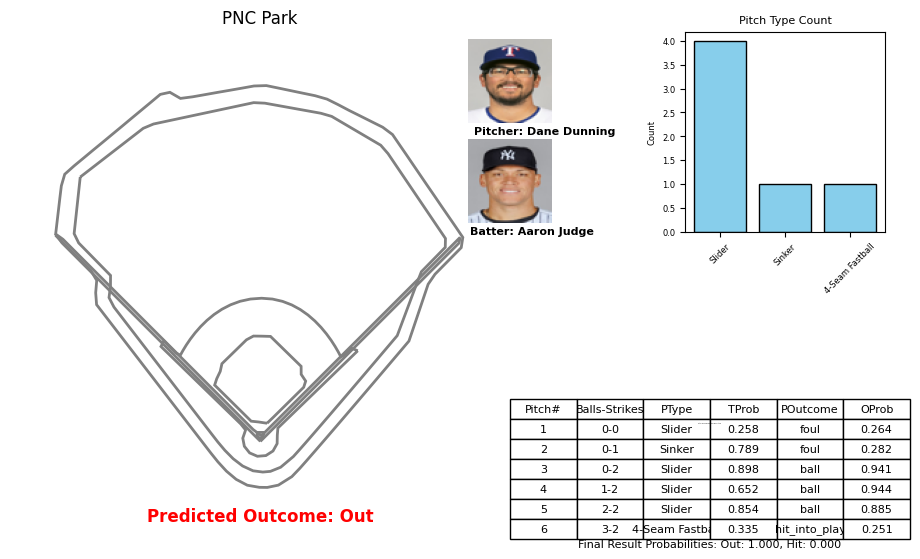

In [36]:
try:
    batID = int(batter_id)
    pitID = int(pitcher_id)
except ValueError:
    batterRow = statcastData[statcastData['batter_id'] == str(batter_id)]
    if not batterRow.empty and 'player_name' in batterRow.columns:
        fullName = batterRow['player_name'].dropna().iloc[0]
        if ',' in fullName:
            last, first = [x.strip().capitalize() for x in fullName.split(',', 1)]
            batterName = f"{first} {last}"
        else:
            batterName = fullName
    else:
        batterName = "Unknown Batter"

    pitcher_row = statcastData[statcastData['pitcher_id'] == str(pitcher_id)]
    if not pitcher_row.empty and 'player_name' in pitcher_row.columns:
        full_name = pitcher_row['player_name'].dropna().iloc[0]
        if ',' in full_name:
            last, first = [x.strip().capitalize() for x in full_name.split(',', 1)]
            pitcherName = f"{first} {last}"
        else:
            pitcherName = full_name
    else:
        pitcherName = "Unknown Pitcher"
else:
    batterInfo = playerid_reverse_lookup([batID], key_type='mlbam')
    batterInfo = batterInfo[batterInfo['key_mlbam'] == batID]
    if batterInfo.empty:
        batter_row = statcastData[statcastData['batter_id'] == str(batter_id)]
        if not batter_row.empty and 'player_name' in batter_row.columns:
            full_name = batter_row['player_name'].dropna().iloc[0]
            if ',' in full_name:
                last, first = [x.strip().capitalize() for x in full_name.split(',', 1)]
                batterName = f"{first} {last}"
            else:
                batterName = full_name
        else:
            batterName = "Unknown Batter"
    else:
        batterName = f"{batterInfo.iloc[0]['name_first'].capitalize()} {batterInfo.iloc[0]['name_last'].capitalize()}"

    pitcherInfo = playerid_reverse_lookup([pitID], key_type='mlbam')
    pitcherInfo = pitcherInfo[pitcherInfo['key_mlbam'] == pitID]
    if pitcherInfo.empty:
        pitcher_row = statcastData[statcastData['pitcher_id'] == str(pitcher_id)]
        if not pitcher_row.empty and 'player_name' in pitcher_row.columns:
            full_name = pitcher_row['player_name'].dropna().iloc[0]
            if ',' in full_name:
                last, first = [x.strip().capitalize() for x in full_name.split(',', 1)]
                pitcherName = f"{first} {last}"
            else:
                pitcherName = full_name
        else:
            pitcherName = "Unknown Pitcher"
    else:
        pitcherName = f"{pitcherInfo.iloc[0]['name_first'].capitalize()} {pitcherInfo.iloc[0]['name_last'].capitalize()}"

batter_image_url = f"https://img.mlbstatic.com/mlb-photos/image/upload/w_213,q_auto:best,f_auto/v1/people/{batter_id}/headshot/67/current"
pitcher_image_url = f"https://img.mlbstatic.com/mlb-photos/image/upload/w_213,q_auto:best,f_auto/v1/people/{pitcher_id}/headshot/67/current"
batterImage = None
pitcherImage = None

try:
    response = requests.get(batter_image_url)
    if response.status_code == 200:
        batterImage = Image.open(BytesIO(response.content))
except:
    pass

try:
    response = requests.get(pitcher_image_url)
    if response.status_code == 200:
        pitcherImage = Image.open(BytesIO(response.content))
except:
    pass
team = 'pirates'
ax = plot_stadium(team)
fig = ax.figure
hc_x, hc_y = None, None
if finalResult == 'Single':
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    hc_x = np.random.uniform(x_min + 75, x_min + 125)
    hc_y = np.random.uniform(y_max - 105, y_max - 155)
elif finalResult == 'Double':
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    hc_x = np.random.uniform(x_min + 50, x_min + 200)
    hc_y = np.random.uniform(y_max - 150, y_max - 75)
elif finalResult == 'Triple':
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    hc_x = np.random.uniform(x_min + 25, x_max - 25)
    hc_y = np.random.uniform(y_min + 50, y_max - 150)
elif finalResult == 'Home Run':
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    hc_x = np.random.uniform(x_min + 100, x_max - 100)
    hc_y = np.random.uniform(y_min + 220, y_max)

if hc_x is not None and hc_y is not None:
    ax.scatter(hc_x, hc_y, color='skyblue', s=150, zorder=5)

batter_coords = (1.0, 0.70)
pitcher_coords = (1.0, 0.90)

if batterImage:
    imagebox = OffsetImage(batterImage.resize((60, 60)), zoom=1)
    ab = AnnotationBbox(imagebox, batter_coords, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

if pitcherImage:
    imagebox = OffsetImage(pitcherImage.resize((60, 60)), zoom=1)
    ab = AnnotationBbox(imagebox, pitcher_coords, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

ax.text(.92, 0.6, f"Batter: {batterName}", fontsize=8, fontweight='bold', ha='left', va='center', transform=ax.transAxes)
ax.text(1.21, 0.80, f"Pitcher: {pitcherName}", fontsize=8, fontweight='bold', ha='right', va='center', transform=ax.transAxes)
ax.text(0.5, 0.02, f"Predicted Outcome: {finalResult}", fontsize=12, fontweight='bold', color='red', ha='center', transform=ax.transAxes)
pitchFrame['pitchTypeProbs'] = pitchFrame['pitchTypeProbs'].apply(lambda x: float(x))
pitchFrame['pitchOutcomeProbs'] = pitchFrame['pitchOutcomeProbs'].apply(lambda x: float(x))
pitchFrame['pitchTypeProbs'] = pitchFrame['pitchTypeProbs'].apply(lambda x: f"{x:.3f}")
pitchFrame['pitchOutcomeProbs'] = pitchFrame['pitchOutcomeProbs'].apply(lambda x: f"{x:.3f}")
table_data = pitchFrame[['Pitch#', 'Balls-Strikes', 'Pitch_Type', 'pitchTypeProbs', 'Pitch_Outcome', 'pitchOutcomeProbs']]
table_data = table_data.rename(columns={'pitchTypeProbs': 'TProb', 'pitchOutcomeProbs': 'OProb'})
table_data = table_data.rename(columns={'Pitch_Type': 'PType', 'Pitch_Outcome': 'POutcome'})
table_ax = fig.add_axes([1.0, 0.05, 0.8, 0.15])
table_ax.axis('off')
table_ax.set_title('Pitch Sequence and Probabilities', fontsize=0)

table = table_ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)
pitch_counts = pitchFrame['Pitch_Type'].value_counts()
pitch_types = pitch_counts.index
counts = pitch_counts.values
chart_ax = fig.add_axes([1.35, 0.6, 0.4, 0.4])
chart_ax.bar(pitch_types, counts, color='skyblue', edgecolor='black')
chart_ax.set_title("Pitch Type Count", fontsize=8)
chart_ax.tick_params(axis='x', rotation=45, labelsize=6)
chart_ax.tick_params(axis='y', labelsize=6)
chart_ax.set_ylabel("Count", fontsize=6)

if finalResult in ['Single', 'Double', 'Triple', 'Home Run', 'Out'] and finalResultProbabilities is not None:
    fr_str = ", ".join([f"{k}: {v:.3f}" for k,v in finalResultProbabilities.items()])
    table_ax.text(0.5, -0.5, f"Final Result Probabilities: {fr_str}",
                  fontsize=8, ha='center', va='center', transform=table_ax.transAxes)
else:
    table_ax.text(0.5, -0.5, "Final Result Probabilities: N/A",
                  fontsize=8, ha='center', va='center', transform=table_ax.transAxes)
plt.show()